In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import scipy.ndimage

# plt.style.use('seaborn-talk')

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

# sns.set(context='talk', style='white', font_scale=1.2)
# sns.set_style("ticks", {"xtick.major.size": 12, "ytick.major.size": 12})

## FUNCTIONS

In [2]:
def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy


def plot_sd(ds, title, time=31, cmap='Blues', vmax=300):
    s = ds.isel(time=time)
    x_gt0 = s.snow.where(s.snow>0)
    x_gt0.plot.imshow(x='x', y='y', cmap=cmap, vmax=vmax, cbar_kwargs={'label': 'Snow Depth [cm]'})
    plt.tight_layout()

    
def equal_kernel(n):
    '''create mean filter with unweighted kernel '''
    k = np.ones((n,n)) * 1./n**2
    return k

def gaussian_kernel(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""

    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

def smooth_over_grid(ds, k, time=31):
    s = ds.isel(time=time)
    smoothed = scipy.ndimage.convolve(s.snow, k)
    return smoothed

(50, 50)


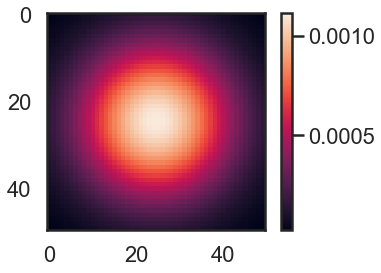

In [4]:
#test gaussian kernel
k = gaussian_kernel(kernlen=50, nsig=2)
print(k.shape)
plt.imshow(k); plt.colorbar()

## DATA INPUTS

In [4]:
dx_input = 1000
flist = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_*{}m*'.format(dx_input))) #bsu

# flist=flist[0]

In [5]:
# flist = [flist]

In [6]:
ds = xr.open_dataset(flist[0]) #quick open to get mask layer of first snow depth file

fpath = '/Users/meganmason491/Documents/research/sierra/data/terrain/*flipped*.nc' #BSU
# fpath = '' #mac

ts=xr.open_mfdataset(fpath, 
                     concat_dim=None, 
                     combine='nested', 
                     chunks={'x':1000, 'y':1000}, 
                     parallel=True) 
ts = ts.where(ds.mask==1)
ts.close()

## MAIN SCRIPT

In [7]:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

# k = equal_kernel(50)
k = gaussian_kernel(kernlen=50, nsig=2) #50*3m pixels = 150 m kernel window
def smoother(f):
    # input (f): file
    # returns (smoothed_ds): xarray dataframe with smoothed snow layer
    
    ds = xr.open_dataset(f)#; ds.close() #open lidar snow depth DataSet in Xarray -- ds
    smooth_holder = np.zeros((51, 335, 335))
    smoothed_ds = ds.copy()
    for t in range(51):
           
        #grab a single time step
        subds = ds.isel(time=t).snow
        # apply the mean smoother filter 
        smooth_holder[t,:,:] = scipy.ndimage.convolve(subds, k, mode='nearest')
        
    # done looping through time 
    # append the smoothed numpy ndarray to the newly copied xarray dataframe
    smoothed_ds['smoothed_snow'] = (('time','y','x'), smooth_holder)
    return smoothed_ds

list_of_smoothed_datasets = []
for f in flist:
    list_of_smoothed_datasets.append(smoother(f))


In [8]:
ds1, ds2, ds3 = list_of_smoothed_datasets

In [9]:
#long names, on x and y (seems like this should have carried through, but really helps the plots...)
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'

ds1.x.attrs['long_name']='Easting'; ds1.x.attrs['units']='m'
ds1.y.attrs['long_name']='Northing'; ds1.y.attrs['units']='m'
ds2.x.attrs['long_name']='Easting'; ds2.x.attrs['units']='m'
ds2.y.attrs['long_name']='Northing'; ds2.y.attrs['units']='m'
ds3.x.attrs['long_name']='Easting'; ds3.x.attrs['units']='m'
ds3.y.attrs['long_name']='Northing'; ds3.y.attrs['units']='m'

#time string format (dd-mon-year)
# ds['time'] = ds['time'].dt.strftime('%d-%b-%Y')
ds1['time'] = ds1['time'].dt.strftime('%d-%b-%Y')
ds2['time'] = ds2['time'].dt.strftime('%d-%b-%Y')
ds3['time'] = ds3['time'].dt.strftime('%d-%b-%Y')

Dana


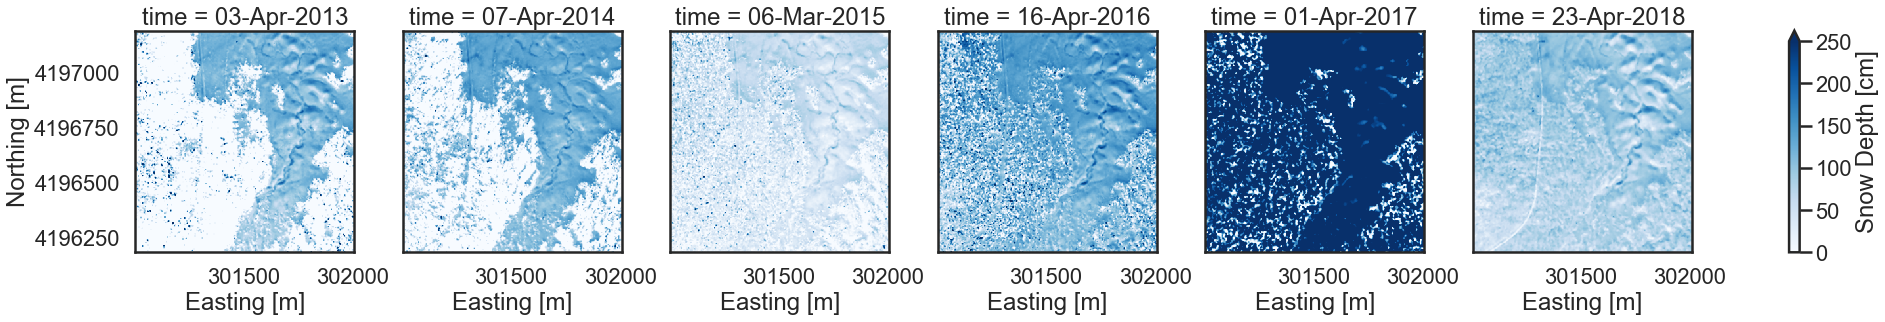

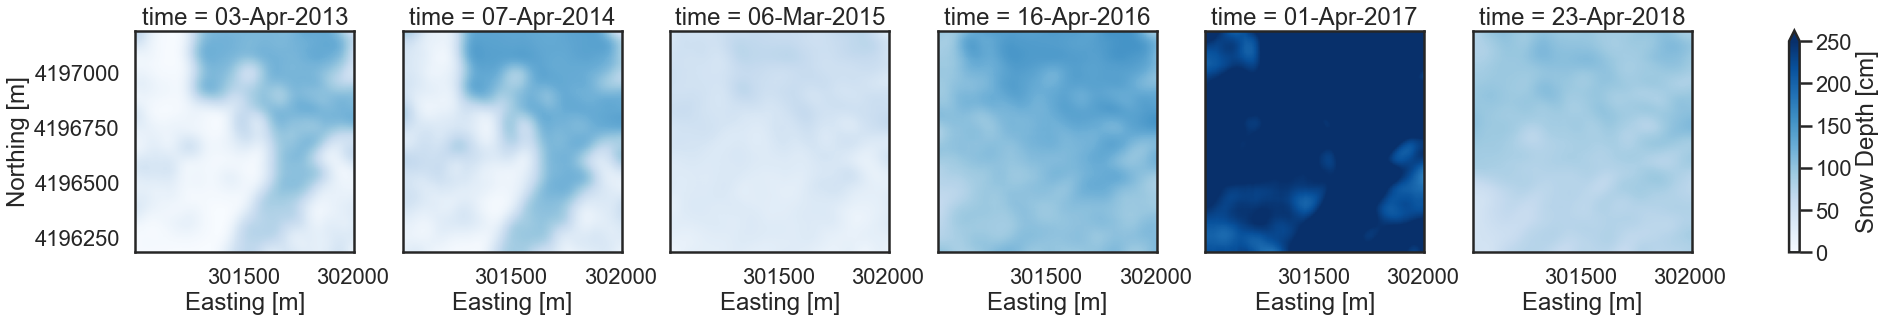

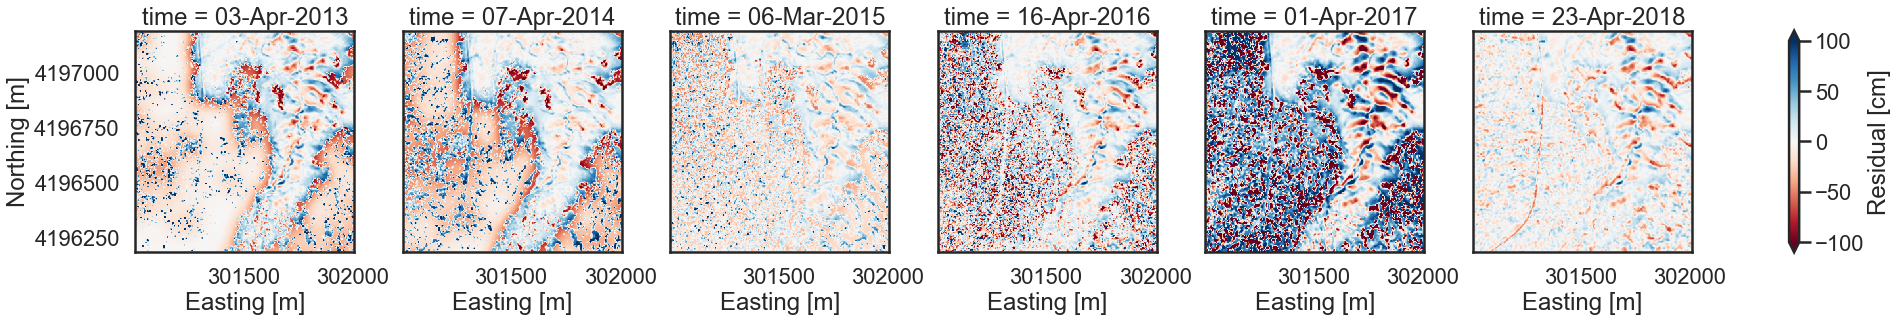

In [10]:
# (smoothed_ds.smoothed_snow - smoothed_ds.snow).plot(x='x', y='y', col='time', col_wrap=10)
# smoothed_ds.smoothed_snow.plot(x='x', y='y', col='time', col_wrap=10)
time = [0,7,18,30,42,49] #[0,7,18,30,42]) #slice(1,51,10))

print('Dana')
#raw
ds1_=ds1.isel(time=time)
h = ds1_.snow.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(30,5));#plt.show()
# plt.savefig('../figs/dan_raw.png', dpi=300, transparent=True)
#smoothe6
ds1_=ds1.isel(time=time)
ds1_.smoothed_snow.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(30,5)); #plt.show()
# plt.savefig('../figs/dan_smooth_150m_gaus2.png', dpi=300, transparent=True)
#differenced
diff = ds1_.snow - ds1_.smoothed_snow
diff.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='RdBu', vmax=100, cbar_kwargs={'label': 'Residual [cm]'}, figsize=(30,5)); #plt.show()
# plt.savefig('../figs/dan_diff_150m_gaus2.png', dpi=300, transparent=True)

# print('Slide')
# #raw
# ds2_=ds2.isel(time=time) #slice(1,51,10))
# ds2_.snow.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(26,4)); #plt.show()
# # plt.savefig('../figs/sli_raw_ex.png', dpi=300)
# #smoothed
# ds2_=ds2.isel(time=time) #=slice(1,51,10))
# ds2_.smoothed_snow.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(26,4)); #plt.show()
# # plt.savefig('../figs/sli_smooth_150m_ex.png', dpi=300)
# #differenced
# diff = ds2_.snow - ds2_.smoothed_snow
# diff.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='RdBu', vmax=100, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(26,4)); #plt.show()
# plt.savefig('../figs/sli_diff_ex.png', dpi=300)

# print('Tuolumne')
# #raw
# ds3_=ds3.isel(time=time) #=slice('2017-01-29','2017-06-04'))
# ds3_.snow.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='Blues', vmax=150, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(26,4)); #plt.show()
# # plt.savefig('../figs/tum_raw_ex.png', dpi=300)
# #smoothed
# ds3_=ds3.isel(time=time) #slice('2017-01-29','2017-06-04'))
# ds3_.smoothed_snow.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='Blues', vmax=150, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(26,4)); #plt.show()
# # plt.savefig('../figs/tum_smooth_150m_ex.png', dpi=300)
# #differenced
# diff = ds3_.snow - ds3_.smoothed_snow
# diff.plot.imshow(x='x', y='y', col='time', col_wrap=len(time), cmap='RdBu', vmax=50, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(26,4)); #plt.show()
# # plt.savefig('../figs/tum_diff_ex.png', dpi=300)

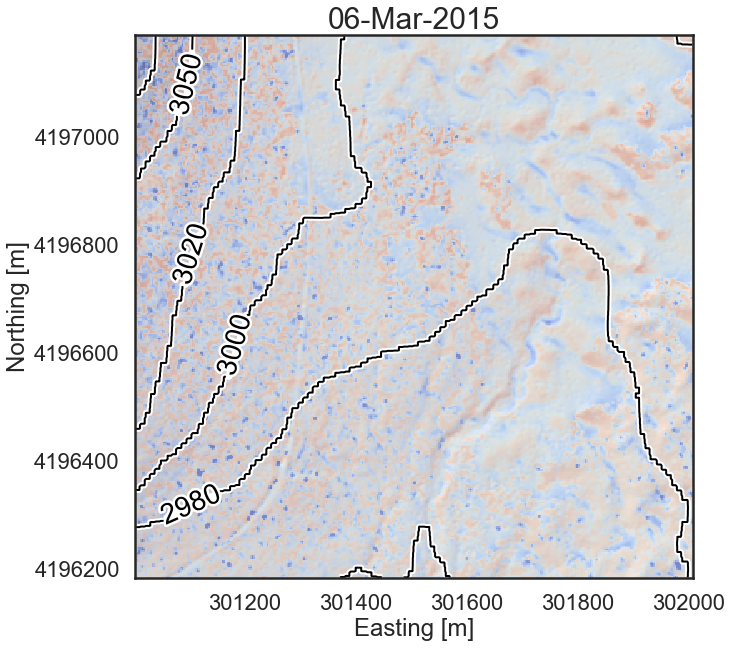

In [18]:
sns.set_style('white')
sns.set_context("poster") 
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 28

#zoom in (2015 vs 2017)
# zoom up fo differences
dsextr = ds1.sel(time=(['06-Mar-2015','16-Apr-2016', '01-Apr-2017']) )

#differenced
diff = dsextr.snow - dsextr.smoothed_snow
# diff.x.attrs['long_name']='Easting'; diff.x.attrs['units']='m'
# diff.y.attrs['long_name']='Northing'; diff.y.attrs['units']='m'

#plot
# plt.figure(figsize=(20,16))
#~~dem
levels=np.round(np.arange(1500,4000,25), -1)
ts.hillshade.plot.imshow(x='x', y='y', cmap='bone', alpha=.45, add_colorbar=False) #.35


#~~differenced
d1 = diff.isel(time=0)
d1.plot.imshow(x='x', y='y', cmap='coolwarm_r', vmax=100, alpha=.5, add_colorbar=False)#cbar_kwargs={'label': 'Residual [cm]'}) #.5

#~~contours
c = ds.dem.plot.contour(x='x', y='y', levels=levels, colors='w', linewidths=6)
c = ds.dem.plot.contour(x='x', y='y', levels=levels, colors='k', linewidths=2)
for text in plt.clabel(c, levels, fmt='%1.0f'):
    text.set_path_effects([PathEffects.withStroke(foreground='white', linewidth=5)])
    
plt.title(d1.time.values, fontsize=30)

plt.savefig('../figs/dan_diff_06Mar2015.png', dpi=300, transparent=True)

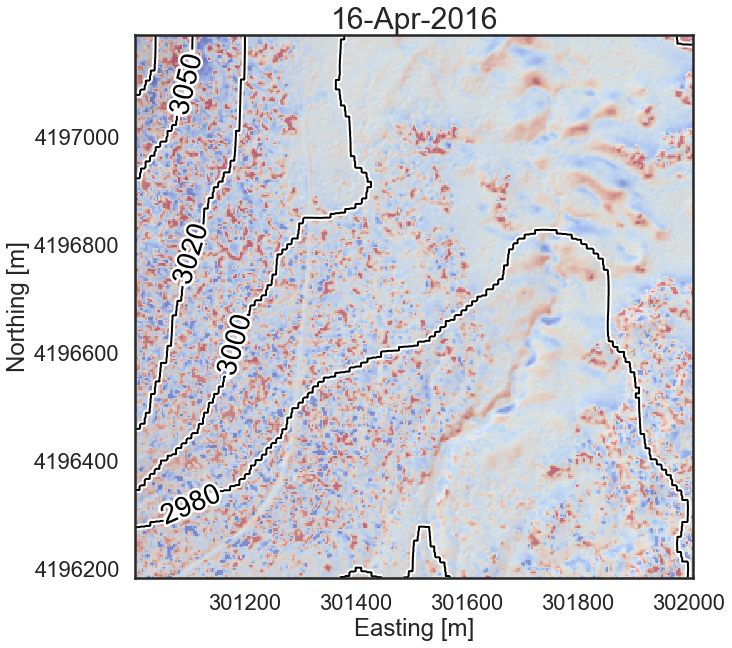

In [19]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 28

#differenced
diff = dsextr.snow - dsextr.smoothed_snow
# diff.x.attrs['long_name']='Easting'; diff.x.attrs['units']='m'
# diff.y.attrs['long_name']='Northing'; diff.y.attrs['units']='m'

#plot
# plt.figure(figsize=(20,16))
#~~dem
levels=np.round(np.arange(1500,4000,25), -1)
ts.hillshade.plot.imshow(x='x', y='y', cmap='bone', alpha=.45, add_colorbar=False) #.35


#~~differenced
d1 = diff.isel(time=1)
d1.plot.imshow(x='x', y='y', cmap='coolwarm_r', vmax=100, alpha=.5, add_colorbar=False)#cbar_kwargs={'label': 'Residual [cm]'}) #.5

#~~contours
c = ds.dem.plot.contour(x='x', y='y', levels=levels, colors='w', linewidths=6)
c = ds.dem.plot.contour(x='x', y='y', levels=levels, colors='k', linewidths=2)
for text in plt.clabel(c, levels, fmt='%1.0f'):
    text.set_path_effects([PathEffects.withStroke(foreground='white', linewidth=5)])
    
plt.title(d1.time.values, fontsize=30)

plt.savefig('../figs/dan_diff_16Apr2016.png', dpi=300, transparent=True)

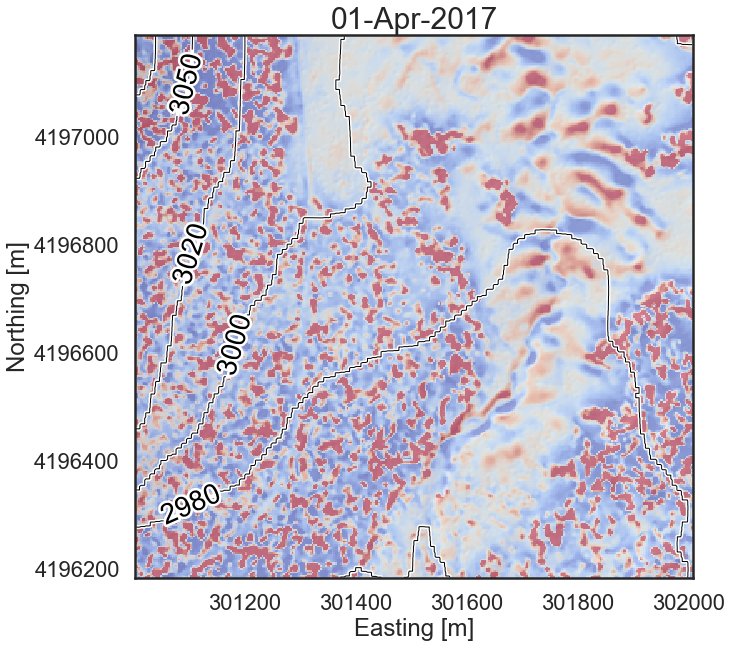

In [20]:
#zoom in (2015 vs 2017)

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 28

#differenced
diff = dsextr.snow - dsextr.smoothed_snow

#plot
# plt.figure(figsize=(20,16))
#~~dem
levels=np.round(np.arange(1500,4000,25), -1)
ts.hillshade.plot.imshow(x='x', y='y', cmap='bone', alpha=.4, add_colorbar=False) 

#~~differenced
d1 = diff.isel(time=2)
d1.plot.imshow(x='x', y='y', cmap='coolwarm_r', vmax=100, alpha=.5, add_colorbar=False)#, cbar_kwargs={'label': 'Residual [cm]'})

#~~contours
c = ds.dem.plot.contour(x='x', y='y', levels=levels, colors='w', linewidths=4)
c = ds.dem.plot.contour(x='x', y='y', levels=levels, colors='k', linewidths=1)
for text in plt.clabel(c, levels, fmt='%1.0f'):
    text.set_path_effects([PathEffects.withStroke(foreground='white', linewidth=5)])
    
plt.title(d1.time.values, fontsize=30)

plt.savefig('../figs/dan_diff_01Apr2017.png', dpi=300, transparent=True)

In [13]:
break

SyntaxError: 'break' outside loop (<ipython-input-13-6aaf1f276005>, line 4)

In [ ]:
# Single time example...
dx_input = 1000
flist = sorted(glob.glob('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_*{}m*'.format(dx_input))) #bsu
f = flist[0]
k = kernel(100)
ds = xr.open_dataset(f); ds.close()
snow_3m = ds.isel(time=31).snow
snow_smooth = scipy.ndimage.convolve(snow_3m, k)
snow_smooth

plt.imshow(snow_smooth, cmap='Blues')
plt.colorbar()




In [ ]:
plt.imshow(snow_3m, cmap='Blues', vmax=300)
plt.colorbar()



In [ ]:
plt.imshow(snow_3m - snow_smooth, cmap='RdBu'); plt.colorbar()

### TEST EVERYTHING

In [ ]:
ds

In [ ]:
ds.x.count().values

In [ ]:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

k = kernel(50)

for i, f in enumerate(flist):
    
        print('Met Station Name:', stns_longname[i], '\n station ID:', stns[i])

        ds = xr.open_dataset(f); ds.close() #open lidar snow depth DataSet in Xarray -- ds

        print('x direction length {} [m]:'.format(ds.x.max().values - ds.x.min().values))
        print('y direction length {} [m]:'.format(ds.y.max().values - ds.y.min().values))

        dx, dy = subregion_size(ds) #subregion size -- used in figure naming

        plot_sd(ds, title=stns_longname[i], vmax=200);plt.show()